# Documentation

**Author:** Anirudh  
**Date:** 16/june/2025  

### Details:
- **Modeling:** Using Linear mixed models now to study the longitudinal changes with respective to Diagnosis (Given BL_DX how cognitive changes overtime with sleep variables)
    - Two types of models to be made : 1. MRI, Cognitive, Sociodemographics. 2. MRI, Cognitive, APOE4, BMI, Cardiovascular risks [Using RID as random effect]
- **Transitions:** Check transitions for Diagnosis and NPIKSEV over time.
    - Flat = no changes 
    - Improves  
    - Worsen 
    - Mixed changes 
- **Changes:** 
    - Using Adjusted_Age instead of AGE.
    - Removing ICV as a covariate for MRI outcomes, instead using it as a predictor
    - Including Viscode/ Adjusted_Age in the model
    - Renamed model to have: outcome_sleep_var
    - Changed the plots now for each sleep_var inclusion
    - Saved the two models after including sociodemographic features into the 2nd model

In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import pickle


In [2]:
merge =pd.read_csv("Latest_all_in_one.csv")

In [3]:
merge

,RID,Sleep_Apnea,Restless_Legs,Insomnia,Sleep_Disturbance_Other,RightEntorhinal,LeftEntorhinal,RightTemporalPole,LeftTemporalPole,RightParahippocampal,...,Adjusted_Age,MH,NPIK,NPIKSEV,BMI,ADNI_MEM,ADNI_EF,ADNI_VS,ADNI_LAN,ADNI_EF2
0,3,0,0,0,0,791.846918,647.947833,1078.037276,1457.480672,1512.146246,...,81.300000,1,0.0,0.0,10.927769,-1.021,-1.144,-0.880,-1.368,-1.062
1,3,0,0,0,0,958.133790,1007.538829,938.695742,1252.944187,1614.977833,...,81.798289,1,0.0,0.0,10.927769,-1.187,-0.674,-1.221,-1.638,-0.670
2,3,0,0,0,0,676.398197,618.004108,1094.889167,1245.740564,1440.387527,...,82.299316,1,0.0,0.0,10.927769,-0.914,-0.969,-0.548,-1.837,-1.034
3,3,0,0,0,0,442.103700,511.055653,1037.524095,1233.834362,1379.850263,...,83.298630,1,0.0,0.0,10.927769,-1.369,-1.511,0.739,-1.700,-1.605
4,5,0,0,0,0,2376.161479,1795.531129,1881.167048,1235.603969,2169.129587,...,73.700000,0,0.0,0.0,12.273373,0.743,0.165,0.739,0.259,-0.152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2083,1425,0,0,0,0,1406.252121,1498.844854,2290.512715,2244.216348,1546.298629,...,77.606840,2,0.0,0.0,0.004549,-1.661,-1.078,0.739,-2.517,-0.826
2084,1427,0,0,0,0,1868.036354,1773.310410,2135.917249,2496.486971,2043.228422,...,69.600000,2,0.0,0.0,72.926002,-0.366,-1.746,-1.530,-0.492,-2.042
2085,1427,0,0,0,0,1568.588612,1982.161848,2109.721786,2320.992933,2000.099965,...,70.079124,2,0.0,0.0,72.926002,-1.445,-1.642,-1.813,-1.640,-1.788
2086,1427,0,0,0,0,1723.941992,1897.426667,2188.880920,2104.616935,1989.621379,...,70.604790,2,1.0,2.0,72.926002,-1.764,-1.625,-0.656,-0.946,-2.047


In [4]:
sleep_cols = ['Sleep_Apnea', 'Restless_Legs',
              'Insomnia', 'Sleep_Disturbance_Other']
merge['MHSleep'] = merge[sleep_cols].sum(axis=1)

In [5]:
cognitive_outcomes = ['ADNI_MEM', 'ADNI_EF', 'ADNI_LAN', 'ADNI_VS', 'ADNI_EF2']
sleep_vars = ['NPIK', 'NPIKSEV', 'MHSleep']
mri_outcomes = ['RightEntorhinal',
 'LeftEntorhinal',
 'RightTemporalPole',
 'LeftTemporalPole',
 'RightParahippocampal',
 'LeftParahippocampal',
 'RightInferiorTemporal',
 'LeftInferiorTemporal',
 'RightMiddleTemporal',
 'LeftMiddleTemporal',
 'RightFusiform',
 'LeftFusiform',
 'RightInferiorParietal',
 'LeftInferiorParietal',
 'RightIsthmusCingulate',
 'LeftIsthmusCingulate',
 'RightBankssts',
 'LeftBankssts',
 'RightPrecuneus',
 'LeftPrecuneus',
 'RightHippocampus',
 'LeftHippocampus',
 'RightAmygdala',
 'LeftAmygdala',
 'RightAccumbensArea',
 'LeftAccumbensArea',
 'RightMedialOrbitofrontal',
 'LeftMedialOrbitofrontal',
 'RightPallidum',
 'LeftPallidum',
 'RightCaudalMiddleFrontal',
 'LeftCaudalMiddleFrontal',
 'RightPutamen',
 'LeftPutamen',
 'RightRostralAnteriorCingulate',
 'LeftRostralAnteriorCingulate',
 'RightParacentral',
 'LeftParacentral',
 'RightPrecentral',
 'LeftPrecentral',
 'RightLingual',
 'LeftLingual',
 'LeftEntorhinal',
 'LeftHippocampus',
 'LeftFusiform',
 'LeftMiddleTemporal',
 'LeftParacentral',
 'RightInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'LeftInferiorLateralVentricle',
 'RightLateralVentricle',
 'LeftLateralVentricle',
 'LeftLateralVentricle']


In [6]:
set(merge.columns) - set(mri_outcomes) - set(cognitive_outcomes) - set(sleep_vars)

{'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX',
 'DX_bl',
 'Insomnia',
 'MH',
 'PTEDUCAT',
 'PTETHCAT',
 'PTGENDER',
 'PTMARRY',
 'PTRACCAT',
 'RID',
 'Restless_Legs',
 'Sleep_Apnea',
 'Sleep_Disturbance_Other',
 'VISCODE'}

In [7]:
merge_scale = merge.copy()

In [8]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for column in merge_scale.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

for column in sleep_vars:
    le = LabelEncoder()
    merge_scale[column] = le.fit_transform(merge_scale[column].astype(str))
    label_encoders[column] = le

In [9]:
label_encoders 

{'VISCODE': LabelEncoder(),
 'DX': LabelEncoder(),
 'DX_bl': LabelEncoder(),
 'PTGENDER': LabelEncoder(),
 'PTETHCAT': LabelEncoder(),
 'PTRACCAT': LabelEncoder(),
 'PTMARRY': LabelEncoder(),
 'NPIK': LabelEncoder(),
 'NPIKSEV': LabelEncoder(),
 'MHSleep': LabelEncoder()}

In [10]:
from sklearn.preprocessing import StandardScaler

continuous_vars = (
    cognitive_outcomes  +
    mri_outcomes + ['BMI', 'Adjusted_Age','MHSleep','Sleep_Apnea','Insomnia']
)
scaler = StandardScaler()
merge_scale[continuous_vars] = scaler.fit_transform(
    merge_scale[continuous_vars])

In [11]:
categorical_vars = ['DX','DX_bl','PTETHCAT','PTGENDER','PTRACCAT']
merge_scale= pd.get_dummies(
    merge_scale, columns=categorical_vars, drop_first=True)

In [12]:
set(merge_scale.columns) - set(mri_outcomes) - \
    set(cognitive_outcomes) - set(sleep_vars)

{'APOE4',
 'Adjusted_Age',
 'BMI',
 'DX_1',
 'DX_2',
 'DX_bl_1',
 'DX_bl_2',
 'Insomnia',
 'MH',
 'PTEDUCAT',
 'PTETHCAT_1',
 'PTETHCAT_2',
 'PTGENDER_1',
 'PTMARRY',
 'PTRACCAT_1',
 'PTRACCAT_2',
 'RID',
 'Restless_Legs',
 'Sleep_Apnea',
 'Sleep_Disturbance_Other',
 'VISCODE'}

In [13]:
model1_preds_mri = ['Adjusted_Age', 'DX_1', 'DX_2', 'PTEDUCAT',
                    'PTETHCAT_2', 'PTGENDER_1', 'PTMARRY', 'PTRACCAT_1']
model1_preds_cog = model1_preds_mri

In [14]:
merge.groupby('DX')['RID'].nunique()

DX
CN          189
Dementia    200
MCI         248
Name: RID, dtype: int64

In [15]:
merge.groupby('DX_bl')['RID'].nunique()

DX_bl
AD      106
CN      178
LMCI    238
Name: RID, dtype: int64

In [18]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model1_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join( model1_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [19]:
import pickle
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [20]:
LMM_results_cognitive_df = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df = pd.DataFrame(sleep_model_results['mri'])

In [16]:
import pickle

cog_frames = []
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}.pkl", 'rb') as f:
        cognitive_results = pickle.load(f)
        cog_frames.append(pd.DataFrame(cognitive_results))

LMM_results_cognitive_df = pd.concat(cog_frames, ignore_index=True)

mri_frames = []
for sleep_var in sleep_vars:
    with open(f"Models/mri_outcomes_{sleep_var}.pkl", 'rb') as f:
        mri_results = pickle.load(f)
        mri_frames.append(pd.DataFrame(mri_results))

LMM_results_mri_df = pd.concat(mri_frames, ignore_index=True)

In [22]:
# def flatten_model_dict_df(nested_df):
#     records = []
#     for col in nested_df.columns:
#         for cell in nested_df[col]:
#             if isinstance(cell, dict):
#                 records.append(cell)
#     return pd.DataFrame(records)

In [23]:
# LMM_results_cognitive_df = flatten_model_dict_df(LMM_results_cognitive_df)
# LMM_results_mri_df = flatten_model_dict_df(LMM_results_mri_df)

In [17]:
LMM_results_cognitive_df 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value
0,model_1,ADNI_MEM,NPIK,Intercept,0.165700,3.078752e-01
1,model_1,ADNI_MEM,NPIK,DX_1[T.True],-1.409966,1.443184e-136
2,model_1,ADNI_MEM,NPIK,DX_2[T.True],-0.875467,1.647205e-71
3,model_1,ADNI_MEM,NPIK,PTETHCAT_2[T.True],0.261182,4.572119e-01
4,model_1,ADNI_MEM,NPIK,PTGENDER_1[T.True],-0.137122,1.450714e-02
...,...,...,...,...,...,...
160,model_15,ADNI_EF2,MHSleep,MHSleep,0.064370,4.838627e-02
161,model_15,ADNI_EF2,MHSleep,Adjusted_Age,-0.126655,2.501543e-05
162,model_15,ADNI_EF2,MHSleep,PTEDUCAT,0.056753,8.609708e-07
163,model_15,ADNI_EF2,MHSleep,PTMARRY,0.033538,3.182397e-01


In [18]:
flat_cog = LMM_results_cognitive_df[~LMM_results_cognitive_df['Feature'].isin(['Intercept', 'Group Var'])]
flat_mri = LMM_results_mri_df[~LMM_results_mri_df['Feature'].isin(['Intercept', 'Group Var'])]

In [19]:
import re


def clean_feature_name(feature):
    match = re.match(r"Q\('(.+)'\)", feature)
    return match.group(1) if match else feature

In [20]:
flat_mri 

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value
1,model_16,RightEntorhinal,NPIK,DX_1[T.True],-0.937758,1.765047e-38
2,model_16,RightEntorhinal,NPIK,DX_2[T.True],-0.545809,3.910233e-17
3,model_16,RightEntorhinal,NPIK,PTETHCAT_2[T.True],0.342465,4.454124e-01
4,model_16,RightEntorhinal,NPIK,PTGENDER_1[T.True],0.003583,9.601557e-01
5,model_16,RightEntorhinal,NPIK,PTRACCAT_1[T.True],0.017643,9.190081e-01
...,...,...,...,...,...,...
1743,model_174,LeftLateralVentricle,MHSleep,PTRACCAT_1[T.True],-0.259875,2.551209e-01
1744,model_174,LeftLateralVentricle,MHSleep,MHSleep,-0.040396,3.600258e-01
1745,model_174,LeftLateralVentricle,MHSleep,Adjusted_Age,0.677269,3.522651e-241
1746,model_174,LeftLateralVentricle,MHSleep,PTEDUCAT,-0.011804,4.480218e-01


In [21]:


flat_cog['Feature'] = flat_cog['Feature'].apply(clean_feature_name)
flat_mri['Feature'] = flat_mri['Feature'].apply(clean_feature_name)

C:\Users\Dark\AppData\Local\Temp\ipykernel_14028\86149613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].apply(clean_feature_name)
C:\Users\Dark\AppData\Local\Temp\ipykernel_14028\86149613.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].apply(clean_feature_name)


In [22]:
flat_cog['Feature'].unique()

array(['DX_1[T.True]', 'DX_2[T.True]', 'PTETHCAT_2[T.True]',
       'PTGENDER_1[T.True]', 'PTRACCAT_1[T.True]', 'NPIK', 'Adjusted_Age',
       'PTEDUCAT', 'PTMARRY', 'NPIKSEV', 'MHSleep'], dtype=object)

In [23]:
feature_rename_map = {
    'DX_1[T.True]': 'Dx_AD',
    'DX_2[T.True]': 'Dx_MCI',
    'PTGENDER_1[T.True]': 'Male',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT_1[T.True]': 'Black',
    'PTETHCAT_1[T.True]': 'Not Hisp/Latino',
    'PTETHCAT_2[T.True]': 'Hispanic/Latino',
    'PTETHCAT_2': 'Unknown Eth'
}
flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)

C:\Users\Dark\AppData\Local\Temp\ipykernel_14028\2199089278.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_cog['Feature'] = flat_cog['Feature'].replace(feature_rename_map)
C:\Users\Dark\AppData\Local\Temp\ipykernel_14028\2199089278.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['Feature'] = flat_mri['Feature'].replace(feature_rename_map)


In [24]:
import math


def plot_lmms_result(df, domain='Cognitive', n_cols=2, p_threshold=0.05):
    sleep_vars = df['Sleep_Variable'].unique()
    n_plots = len(sleep_vars)
    n_rows = math.ceil(n_plots / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5), squeeze=False)

    for idx, sleep_var in enumerate(sleep_vars):
        row, col = divmod(idx, n_cols)
        ax = axes[row][col]

        df_plot = df[df['Sleep_Variable'] == sleep_var]
        sleep_feat = sleep_var
        df_others = df_plot[df_plot['Feature'] != sleep_feat]
        sns.barplot(
            data=df_others,
            x='Coefficient',
            y='Outcome',
            hue='Feature',
            dodge=True,
            palette='tab10',
            ax=ax,
            alpha=0.7
        )
        df_sleep = df_plot[df_plot['Feature'] == sleep_feat]
        if not df_sleep.empty:
            sns.barplot(
                data=df_sleep,
                x='Coefficient',
                y='Outcome',
                color='crimson',
                ax=ax,
                label=sleep_feat,
                dodge=True,
                alpha=0.5,
                linewidth=2,
                edgecolor='black'
            )
        ax.axvline(x=0, color='red', linestyle='--')
        significant = df_plot[df_plot['P-Value'] < p_threshold]
        if not significant.empty:
            threshold = 0.05
            ax.axvline(x=threshold, color='green', linestyle=':', label=f'Significance Threshold ({p_threshold})')
            ax.axvline(x=-threshold, color='green', linestyle=':')

        ax.set_title(f'{sleep_var}', fontsize=12)
        ax.set_xlabel('Coefficient')
        ax.set_ylabel('Outcome')
        ax.legend_.remove()
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels[:-1], bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.legend([handles[-1]], ['Sleep-Variable'], title='Predictor', bbox_to_anchor=(1.02, 1.05), loc='upper left')

    fig.suptitle(f'LMMs Coefficients: Sleep Variables on {domain} Outcomes', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.88, 0.97])
    plt.show()



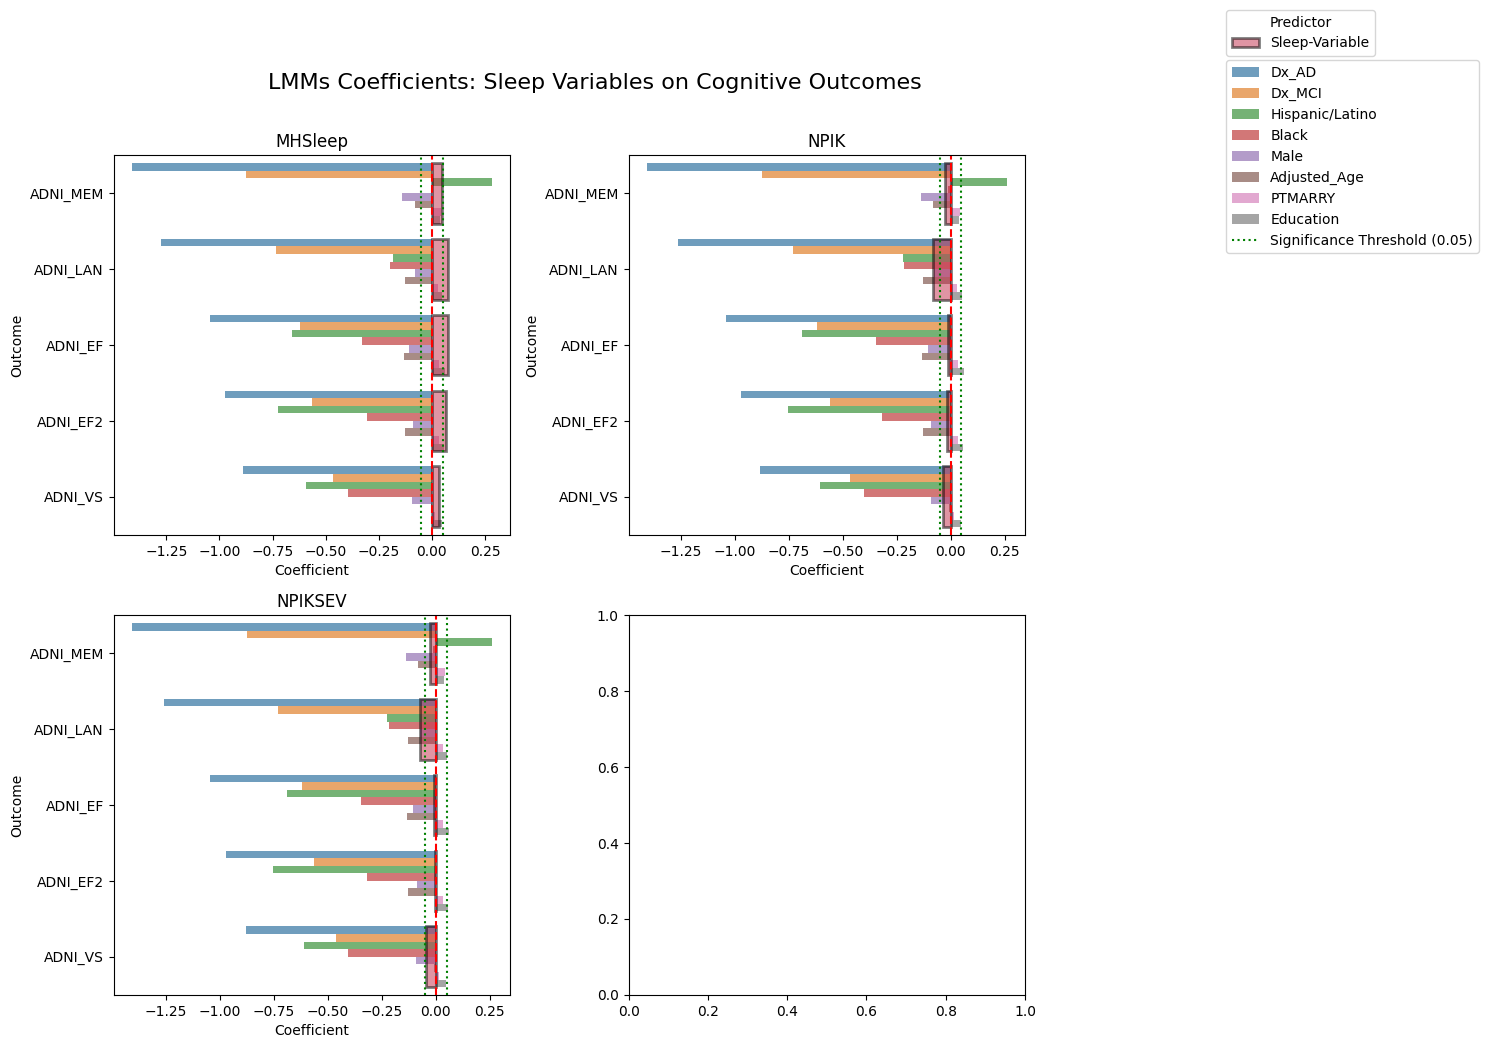

In [25]:

plot_lmms_result(flat_cog.sort_values(by='Coefficient'), domain='Cognitive', n_cols=2)

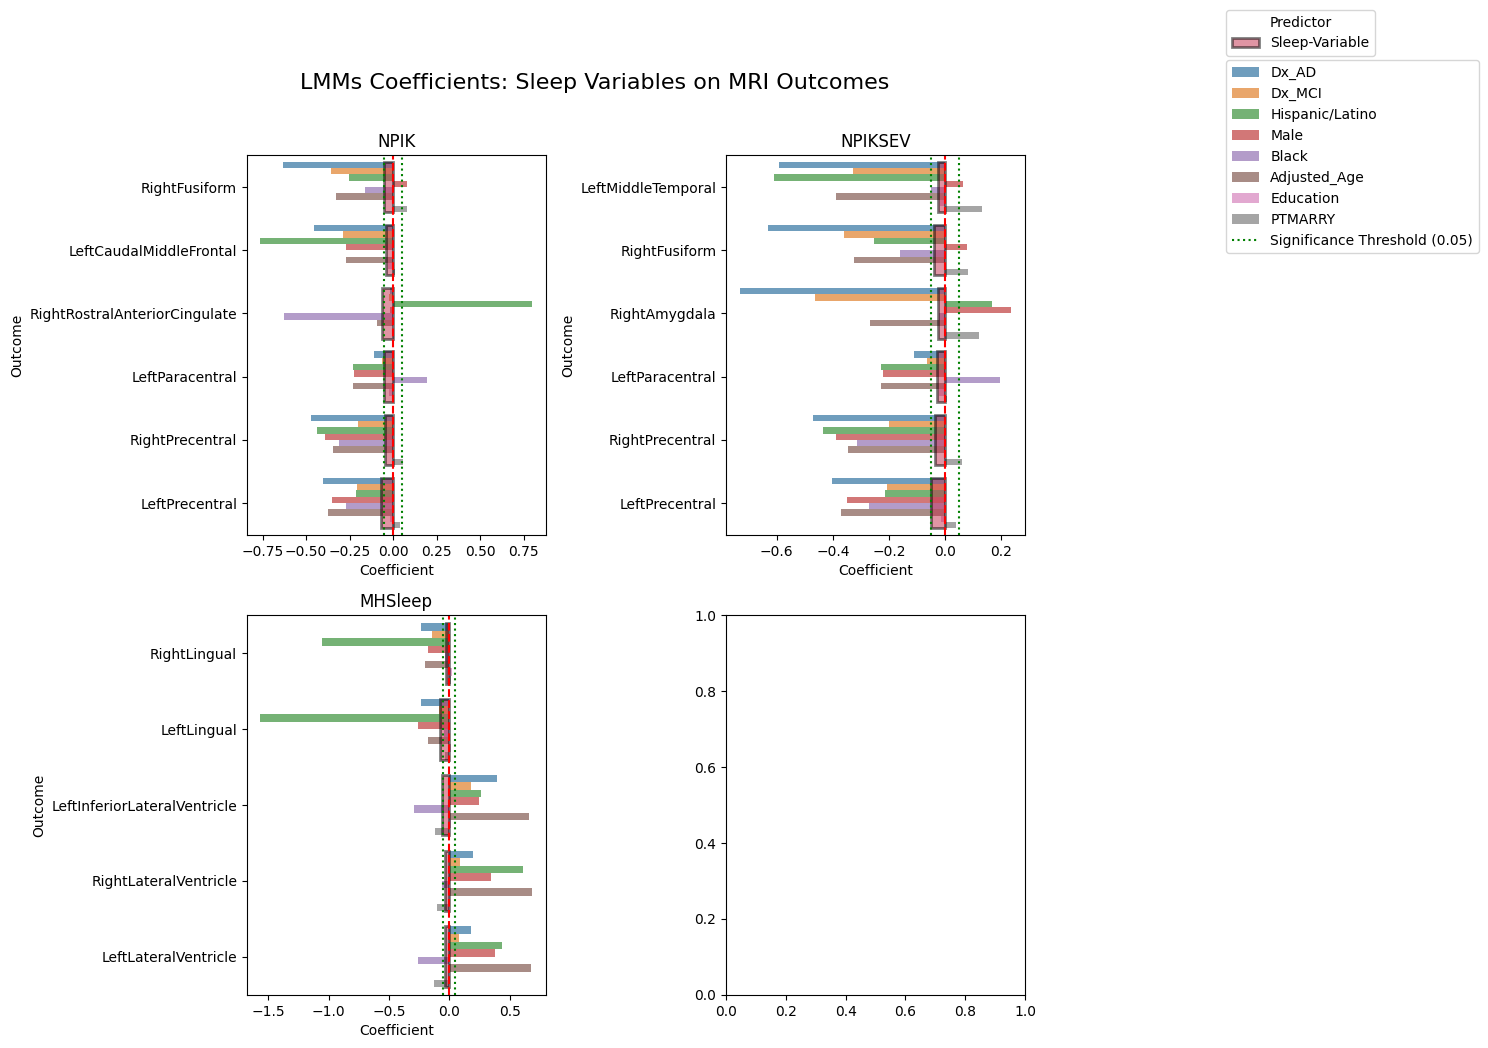

In [26]:
all_df_top = []

for sleep_var in flat_mri['Sleep_Variable'].unique():
    df_plot = flat_mri[flat_mri['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient')
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(7)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI')

In [27]:
# --- Generate Summary Table from flat_mri --- #

# Convert scientific notation if needed
flat_mri['P-Value'] = pd.to_numeric(flat_mri['P-Value'], errors='coerce')

# Get unique outcomes and sleep variables
mri_outcomes = flat_mri['Outcome'].unique()
sleep_vars = flat_mri['Sleep_Variable'].unique()

# Initialize empty DataFrame
summary_mri = pd.DataFrame(index=mri_outcomes, columns=sleep_vars)

# Fill table with formatted coefficients
for outcome in mri_outcomes:
    for sleep_var in sleep_vars:
        # Filter to relevant row
        subset = flat_mri[
            (flat_mri['Outcome'] == outcome) &
            (flat_mri['Sleep_Variable'] == sleep_var) &
            (flat_mri['Feature'] == sleep_var)  # Only keep main sleep feature, not covariates
        ]
        if not subset.empty:
            coef = subset['Coefficient'].values[0]
            pval = subset['P-Value'].values[0]
            formatted = f"{coef:.3f}{'*' if pval < 0.05 else ''}"
            summary_mri.loc[outcome, sleep_var] = formatted
        else:
            summary_mri.loc[outcome, sleep_var] = '—'

# Optional: clean up
summary_mri = summary_mri.fillna('—')
print(summary_mri.to_string())


C:\Users\Dark\AppData\Local\Temp\ipykernel_14028\3841013037.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flat_mri['P-Value'] = pd.to_numeric(flat_mri['P-Value'], errors='coerce')


                                  NPIK  NPIKSEV MHSleep
RightEntorhinal                  0.012   -0.003   0.049
LeftEntorhinal                  -0.013   -0.021   0.042
RightTemporalPole               -0.032   -0.014   0.064
LeftTemporalPole                 0.018   -0.009   0.039
RightParahippocampal            -0.003   -0.021   0.004
LeftParahippocampal             -0.016   -0.017   0.038
RightInferiorTemporal            0.001   -0.014  0.079*
LeftInferiorTemporal            -0.009   -0.015  0.088*
RightMiddleTemporal             -0.014   -0.016   0.048
LeftMiddleTemporal              -0.034   -0.025   0.047
RightFusiform                  -0.052*  -0.041*  0.098*
LeftFusiform                    -0.034   -0.023   0.054
RightInferiorParietal           -0.005   -0.002  0.143*
LeftInferiorParietal            -0.002   -0.009  0.106*
RightIsthmusCingulate           -0.011   -0.011   0.070
LeftIsthmusCingulate             0.015   -0.009   0.051
RightBankssts                   -0.006   -0.013 

In [28]:
model2_preds_cog = ['APOE4', 'BMI','MH',] + model1_preds_cog
model2_preds_mri = ['APOE4', 'BMI', 'MH',] + model1_preds_mri

In [29]:
model2_preds_cog 

['APOE4',
 'BMI',
 'MH',
 'Adjusted_Age',
 'DX_1',
 'DX_2',
 'PTEDUCAT',
 'PTETHCAT_2',
 'PTGENDER_1',
 'PTMARRY',
 'PTRACCAT_1']

In [37]:
from collections import defaultdict

sleep_model_results = {
    'cognitive': defaultdict(list),
    'mri': defaultdict(list)
}

model_counter = 1


def store_all_predictors(result, outcome, sleep_var, domain):
    records = []
    for predictor in result.params.index:
        records.append({
            'Model_ID': f"model_{model_counter}",
            'Outcome': outcome,
            'Sleep_Variable': sleep_var,
            'Feature': predictor,
            'Coefficient': result.params.get(predictor, float('nan')),
            'P-Value': result.pvalues.get(predictor, float('nan')),
        })
    return records


for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(
                result, outcome, sleep_var, 'cognitive')
            sleep_model_results['cognitive'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[Cognitive] Error for {outcome} with {sleep_var}: {e}")

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join( model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale,
                                groups=merge_scale["RID"])
            result = model.fit(reml=False)

            results = store_all_predictors(result, outcome, sleep_var, 'mri')
            sleep_model_results['mri'][sleep_var].extend(results)
            model_counter += 1
        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

In [38]:
LMM_results_cognitive_df_sd = pd.DataFrame(sleep_model_results['cognitive'])
LMM_results_mri_df_sd = pd.DataFrame(sleep_model_results['mri'])

In [39]:
for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['cognitive'][sleep_var], f)

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'wb') as f:
        pickle.dump(sleep_model_results['mri'][sleep_var], f)

In [36]:
# LMM_results_cog_df = flatten_model_dict_df(LMM_results_cognitive_df_sd)
# LMM_results_mri_df = flatten_model_dict_df(LMM_results_mri_df_sd)

In [30]:
cog_frames = []
mri_frames = []

for sleep_var in sleep_vars:
    with open(f"Models/cognitive_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        cognitive_results = pickle.load(f)
        cog_frames.append(pd.DataFrame(cognitive_results))

    with open(f"Models/mri_outcomes_{sleep_var}_sd.pkl", 'rb') as f:
        mri_results = pickle.load(f)
        mri_frames.append(pd.DataFrame(mri_results))

LMM_results_cognitive_df_sd = pd.concat(cog_frames, ignore_index=True)
LMM_results_mri_df_sd = pd.concat(mri_frames, ignore_index=True)

In [31]:
LMM_results_cognitive_df_sd = LMM_results_cognitive_df_sd[~LMM_results_cognitive_df_sd['Feature'].isin( ['Group Var','Intercept'])]
LMM_results_mri_df_sd = LMM_results_mri_df_sd[~LMM_results_mri_df_sd['Feature'].isin( ['Group Var', 'Intercept'])]

In [32]:
LMM_results_cognitive_df_sd['Feature'] = LMM_results_cognitive_df_sd['Feature'].apply(clean_feature_name)
LMM_results_mri_df_sd['Feature'] = LMM_results_mri_df_sd['Feature'].apply(clean_feature_name)

In [33]:
LMM_results_cognitive_df

,Model_ID,Outcome,Sleep_Variable,Feature,Coefficient,P-Value
0,model_1,ADNI_MEM,NPIK,Intercept,0.165700,3.078752e-01
1,model_1,ADNI_MEM,NPIK,DX_1[T.True],-1.409966,1.443184e-136
2,model_1,ADNI_MEM,NPIK,DX_2[T.True],-0.875467,1.647205e-71
3,model_1,ADNI_MEM,NPIK,PTETHCAT_2[T.True],0.261182,4.572119e-01
4,model_1,ADNI_MEM,NPIK,PTGENDER_1[T.True],-0.137122,1.450714e-02
...,...,...,...,...,...,...
160,model_15,ADNI_EF2,MHSleep,MHSleep,0.064370,4.838627e-02
161,model_15,ADNI_EF2,MHSleep,Adjusted_Age,-0.126655,2.501543e-05
162,model_15,ADNI_EF2,MHSleep,PTEDUCAT,0.056753,8.609708e-07
163,model_15,ADNI_EF2,MHSleep,PTMARRY,0.033538,3.182397e-01


In [34]:
from scipy.stats import shapiro, skew, kurtosis
import pandas as pd
import statsmodels.formula.api as smf

normality_results_cog = []

for sleep_var in sleep_vars:
    for outcome in cognitive_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale, groups=merge_scale["RID"])
            result = model.fit(reml=False)

            # Residuals
            residuals = result.resid.dropna()
            n = len(residuals)
            if n < 3:
                continue

            # Shapiro–Wilk
            stat, p = shapiro(residuals)
            skew_val = skew(residuals)
            kurt_val = kurtosis(residuals)

            is_normal = p > 0.05
            clt_applies = not is_normal and n >= 30

            normality_results_cog.append({
                'Outcome': outcome,
                'Sleep_Variable': sleep_var,
                'N': n,
                'Shapiro_p': round(p, 6),
                'Skewness': round(skew_val, 3),
                'Kurtosis': round(kurt_val, 3),
                'Normal?': 'Yes ✅' if is_normal else 'No ❌',
                'CLT Applies?': 'Yes ✅' if clt_applies else ('—' if is_normal else 'No ❌')
            })

        except Exception as e:
            print(f"[Cog] Error for {outcome} with {sleep_var}: {e}")

normality_df_cog = pd.DataFrame(normality_results_cog)
print("\n🧠 Cognitive Residual Normality:\n")
print(normality_df_cog.to_string(index=False))



🧠 Cognitive Residual Normality:

 Outcome Sleep_Variable    N  Shapiro_p  Skewness  Kurtosis Normal? CLT Applies?
ADNI_MEM           NPIK 2088        0.0    -0.310     2.078    No ❌        Yes ✅
 ADNI_EF           NPIK 2088        0.0    -0.390     1.609    No ❌        Yes ✅
ADNI_LAN           NPIK 2088        0.0    -0.428     1.407    No ❌        Yes ✅
 ADNI_VS           NPIK 2088        0.0    -0.332     0.568    No ❌        Yes ✅
ADNI_EF2           NPIK 2088        0.0    -0.490     2.218    No ❌        Yes ✅
ADNI_MEM        NPIKSEV 2088        0.0    -0.302     2.023    No ❌        Yes ✅
 ADNI_EF        NPIKSEV 2088        0.0    -0.390     1.605    No ❌        Yes ✅
ADNI_LAN        NPIKSEV 2088        0.0    -0.412     1.300    No ❌        Yes ✅
 ADNI_VS        NPIKSEV 2088        0.0    -0.331     0.554    No ❌        Yes ✅
ADNI_EF2        NPIKSEV 2088        0.0    -0.490     2.231    No ❌        Yes ✅
ADNI_MEM        MHSleep 2088        0.0    -0.315     2.108    No ❌        

In [35]:
normality_results_mri = []

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            model = smf.mixedlm(formula, data=merge_scale, groups=merge_scale["RID"])
            result = model.fit(reml=False)

            # Residuals
            residuals = result.resid.dropna()
            n = len(residuals)
            if n < 3:
                continue

            # Shapiro–Wilk
            stat, p = shapiro(residuals)
            skew_val = skew(residuals)
            kurt_val = kurtosis(residuals)

            is_normal = p > 0.05
            clt_applies = not is_normal and n >= 30

            normality_results_mri.append({
                'Outcome': outcome,
                'Sleep_Variable': sleep_var,
                'N': n,
                'Shapiro_p': round(p, 5),
                'Skewness': round(skew_val, 3),
                'Kurtosis': round(kurt_val, 3),
                'Normal?': 'Yes ✅' if is_normal else 'No ❌',
                'CLT Applies?': 'Yes ✅' if clt_applies else ('—' if is_normal else 'No ❌')
            })

        except Exception as e:
            print(f"[MRI] Error for {outcome} with {sleep_var}: {e}")

normality_df_mri = pd.DataFrame(normality_results_mri)
print("\n🧪 MRI Residual Normality:\n")
print(normality_df_mri.to_string(index=False))



🧪 MRI Residual Normality:

                      Outcome Sleep_Variable    N  Shapiro_p  Skewness  Kurtosis Normal? CLT Applies?
              RightEntorhinal           NPIK 2088    0.00000     0.389     1.726    No ❌        Yes ✅
               LeftEntorhinal           NPIK 2088    0.00000     0.552     2.468    No ❌        Yes ✅
            RightTemporalPole           NPIK 2088    0.00000     0.296     2.310    No ❌        Yes ✅
             LeftTemporalPole           NPIK 2088    0.00000     0.275     1.352    No ❌        Yes ✅
         RightParahippocampal           NPIK 2088    0.00000     0.452     2.845    No ❌        Yes ✅
          LeftParahippocampal           NPIK 2088    0.00000     0.478     4.420    No ❌        Yes ✅
        RightInferiorTemporal           NPIK 2088    0.00000    -0.021     2.951    No ❌        Yes ✅
         LeftInferiorTemporal           NPIK 2088    0.00000     0.037     1.285    No ❌        Yes ✅
          RightMiddleTemporal           NPIK 2088    0

In [36]:
feature_rename_map = {
    'DX_1[T.True]': 'Dx_AD',
    'DX_2[T.True]': 'Dx_MCI',
    'PTGENDER_1[T.True]': 'Male',
    'PTEDUCAT': 'Education',
    'AGE': 'Age',
    'PTRACCAT_1[T.True]': 'Black',
    'PTETHCAT_1[T.True]': 'Not Hisp/Latino',
    'PTETHCAT_2[T.True]': 'Hispanic/Latino',
    "MH": "Medical History"
}

LMM_results_cognitive_df_sd['Feature'] = LMM_results_cognitive_df_sd['Feature'].replace(feature_rename_map)
LMM_results_mri_df_sd['Feature'] = LMM_results_mri_df_sd['Feature'].replace(feature_rename_map)

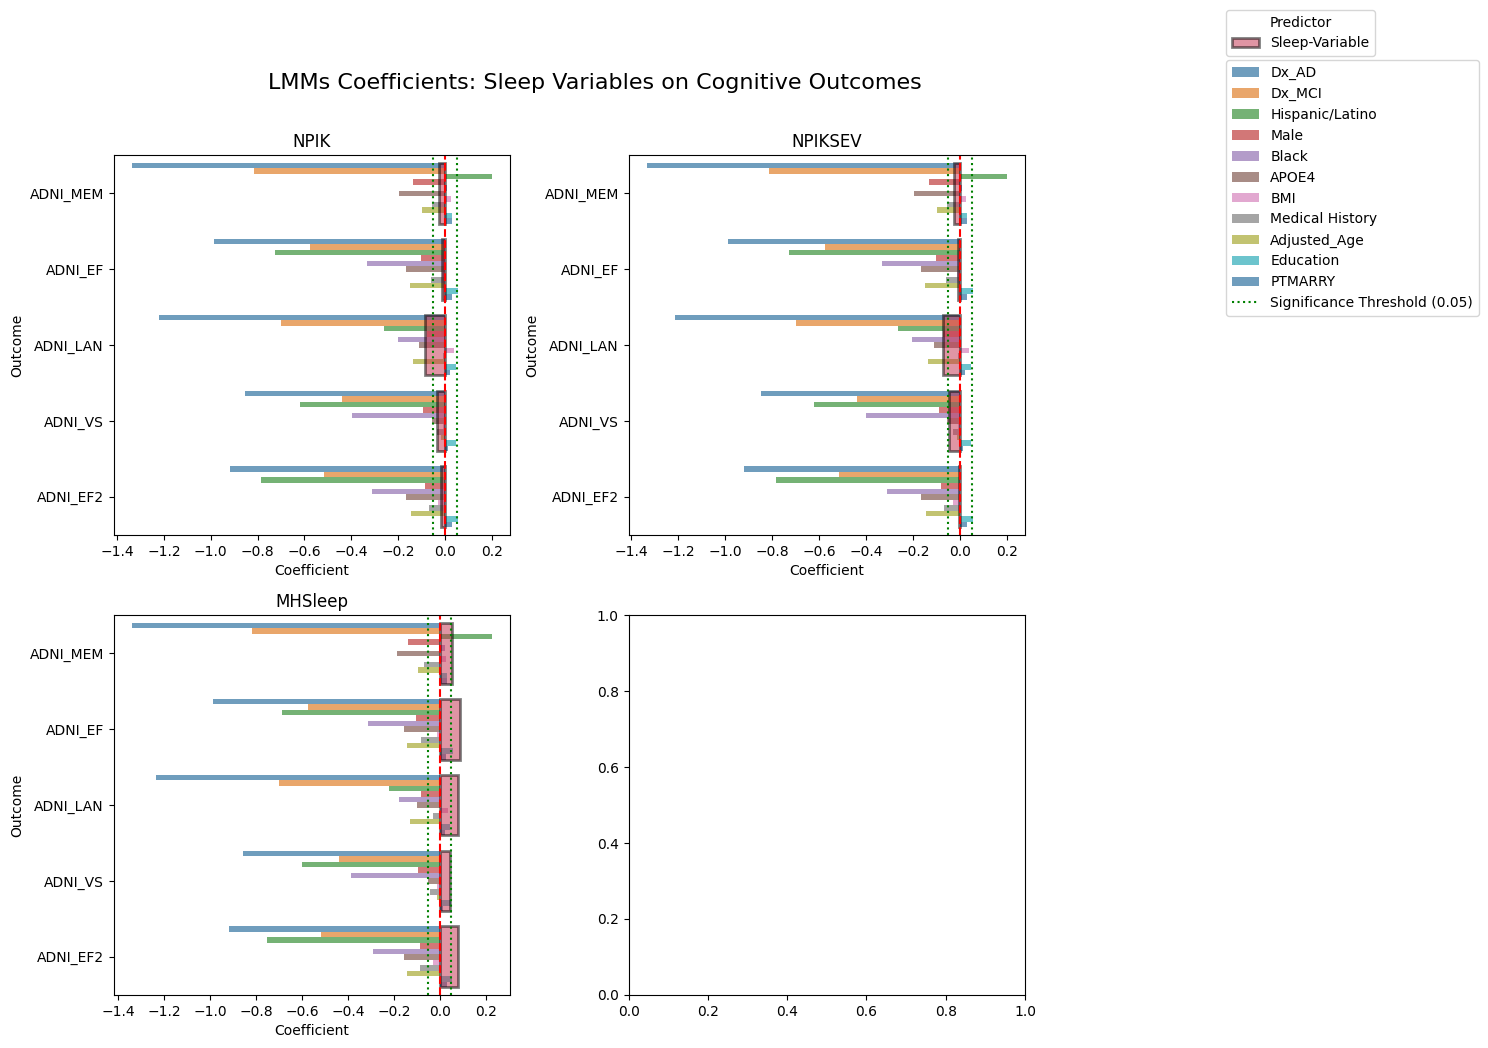

In [37]:
plot_lmms_result(LMM_results_cognitive_df_sd, domain='Cognitive', n_cols=2)

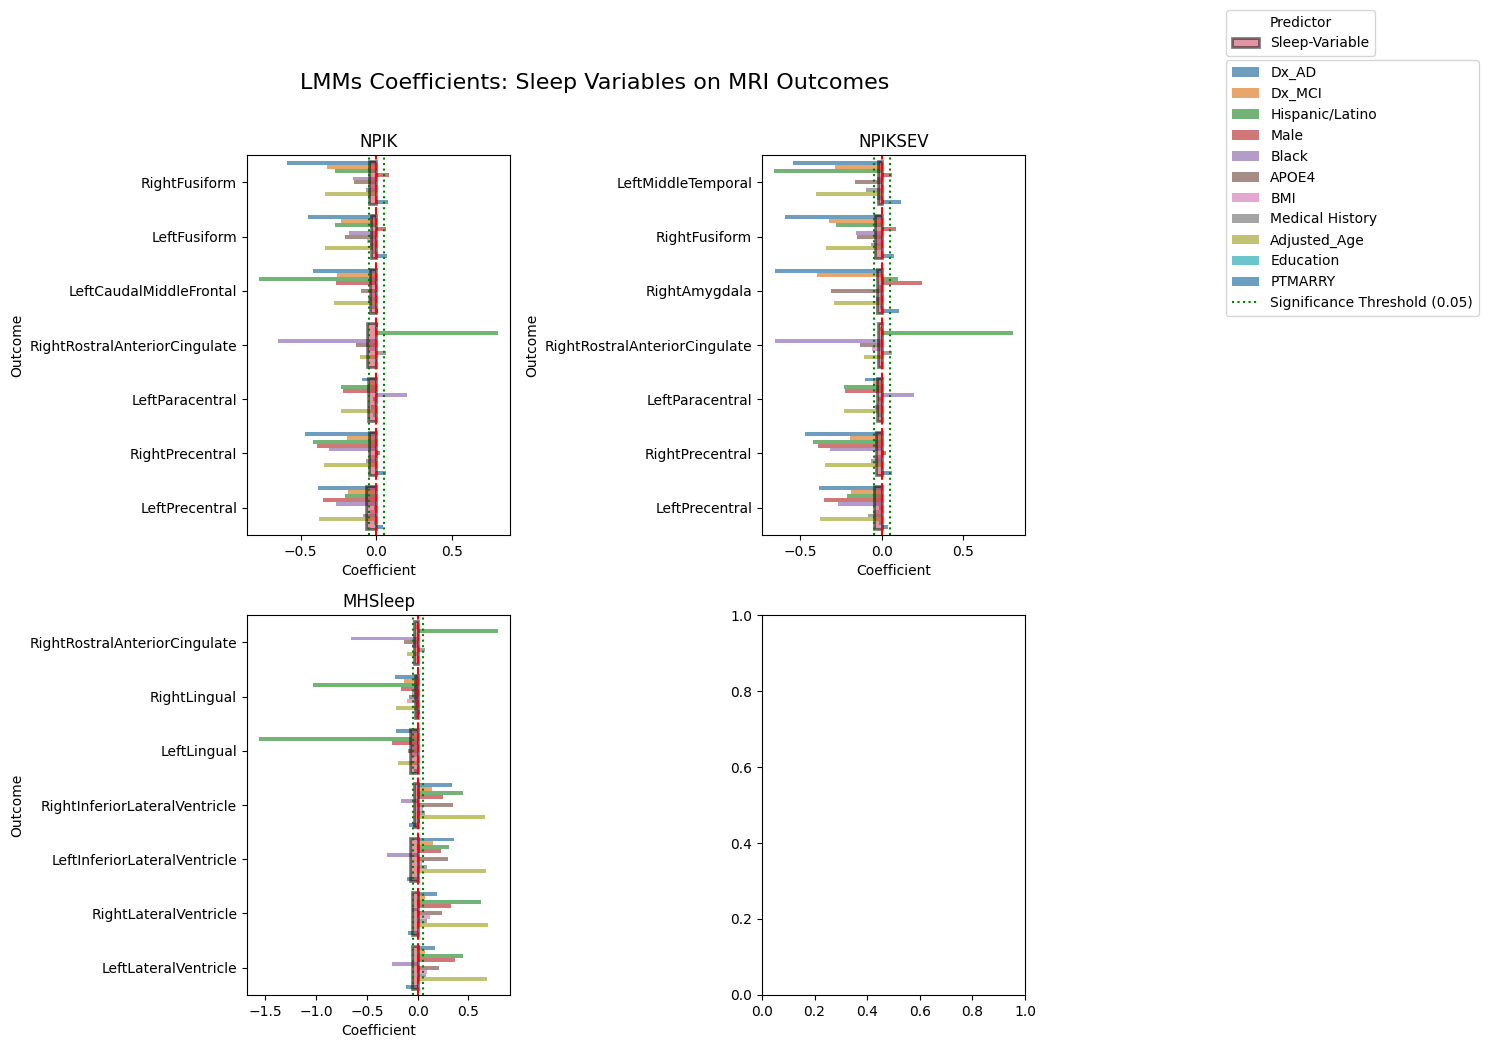

In [40]:
all_df_top = []

for sleep_var in LMM_results_mri_df_sd['Sleep_Variable'].unique():
    df_plot = LMM_results_mri_df_sd[LMM_results_mri_df_sd['Sleep_Variable'] == sleep_var]

    top_outcomes = (
        df_plot[df_plot['Feature'] == sleep_var].sort_values(by='Coefficient',ascending=True)
        .set_index('Outcome')['Coefficient']
        .abs()
        .head(7)
        .index
    )

    df_top = df_plot[df_plot['Outcome'].isin(top_outcomes)]
    all_df_top.append(df_top)

df_top_all = pd.concat(all_df_top, ignore_index=True)
plot_lmms_result(df_top_all, domain='MRI',n_cols=2)

In [41]:
import statsmodels.formula.api as smf
from scipy import stats

anova_results = []

for sleep_var in sleep_vars:
    for outcome in mri_outcomes:
        try:
            # Full model
            full_formula = f"{outcome} ~ {sleep_var} + {' + '.join(model2_preds_cog)}"
            full_model = smf.mixedlm(full_formula, data=merge_scale, groups=merge_scale["RID"])
            full_result = full_model.fit(reml=False)

            # Reduced model (remove sleep variable)
            reduced_formula = f"{outcome} ~ {' + '.join(model2_preds_cog)}"
            reduced_model = smf.mixedlm(reduced_formula, data=merge_scale, groups=merge_scale["RID"])
            reduced_result = reduced_model.fit(reml=False)

            # Likelihood ratio test (equivalent to ANOVA for mixed model)
            lr_stat = 2 * (full_result.llf - reduced_result.llf)
            p_value = stats.chi2.sf(lr_stat, df=1)  # df = 1 because 1 term removed

            anova_results.append({
                'Outcome': outcome,
                'Sleep_Variable': sleep_var,
                'LR_Statistic': lr_stat,
                'p_value': p_value
            })

        except Exception as e:
            print(f"[ANOVA] Error for {outcome} with {sleep_var}: {e}")

anova_df = pd.DataFrame(anova_results)
print(anova_df)


                           Outcome Sleep_Variable  LR_Statistic   p_value
0                  RightEntorhinal           NPIK      0.078622  0.779174
1                   LeftEntorhinal           NPIK      0.133681  0.714646
2                RightTemporalPole           NPIK      0.611503  0.434223
3                 LeftTemporalPole           NPIK      0.202516  0.652698
4             RightParahippocampal           NPIK      0.011257  0.915504
..                             ...            ...           ...       ...
133                    LeftLingual        MHSleep      3.152794  0.075797
134  RightInferiorLateralVentricle        MHSleep      0.643854  0.422319
135   LeftInferiorLateralVentricle        MHSleep      2.875457  0.089939
136          RightLateralVentricle        MHSleep      1.491624  0.221965
137           LeftLateralVentricle        MHSleep      1.535396  0.215304

[138 rows x 4 columns]


In [42]:
anova_df[anova_df['p_value'] < 0.05]

,Outcome,Sleep_Variable,LR_Statistic,p_value
10,RightFusiform,NPIK,4.481483,0.034264
32,RightPutamen,NPIK,3.872169,0.049093
42,RightInferiorLateralVentricle,NPIK,3.946459,0.046970
56,RightFusiform,NPIKSEV,6.391646,0.011466
74,RightPallidum,NPIKSEV,4.662459,0.030829
85,LeftPrecentral,NPIKSEV,4.835343,0.027882
88,RightInferiorLateralVentricle,NPIKSEV,14.167177,0.000167
89,LeftInferiorLateralVentricle,NPIKSEV,8.460467,0.003629
90,RightLateralVentricle,NPIKSEV,10.078879,0.001500
91,LeftLateralVentricle,NPIKSEV,8.857527,0.002919


In [44]:
# --- Generate Summary Table from LMM_results_mri_df_sd --- #

# Convert scientific notation if needed
LMM_results_mri_df_sd['P-Value'] = pd.to_numeric(LMM_results_mri_df_sd['P-Value'], errors='coerce')

# Get unique outcomes and sleep variables
mri_outcomes = LMM_results_mri_df_sd['Outcome'].unique()
sleep_vars = LMM_results_mri_df_sd['Sleep_Variable'].unique()

# Initialize empty DataFrame
summary_mri = pd.DataFrame(index=mri_outcomes, columns=sleep_vars)

# Fill table with formatted coefficients
for outcome in mri_outcomes:
    for sleep_var in sleep_vars:
        # Filter to relevant row
        subset = LMM_results_mri_df_sd[
            (LMM_results_mri_df_sd['Outcome'] == outcome) &
            (LMM_results_mri_df_sd['Sleep_Variable'] == sleep_var) &
            (LMM_results_mri_df_sd['Feature'] == sleep_var)  # Only keep main sleep feature, not covariates
        ]
        if not subset.empty:
            coef = subset['Coefficient'].values[0]
            pval = subset['P-Value'].values[0]
            formatted = f"{coef:.3f}{'*' if pval < 0.05 else ''}"
            summary_mri.loc[outcome, sleep_var] = formatted
        else:
            summary_mri.loc[outcome, sleep_var] = '—'

# Optional: clean up
summary_mri = summary_mri.fillna('—')
summary_mri 

,NPIK,NPIKSEV,MHSleep
RightEntorhinal,0.011,-0.004,0.054
LeftEntorhinal,-0.014,-0.020,0.051
RightTemporalPole,-0.033,-0.014,0.066
LeftTemporalPole,0.018,-0.008,0.047
RightParahippocampal,-0.003,-0.021,0.016
LeftParahippocampal,-0.017,-0.017,0.041
RightInferiorTemporal,0.001,-0.014,0.099*
LeftInferiorTemporal,-0.009,-0.014,0.111*
RightMiddleTemporal,-0.014,-0.016,0.049
LeftMiddleTemporal,-0.034,-0.025,0.068


In [43]:
from scipy import stats
import statsmodels.api as sm

def run_anova_and_normality_from_lasso(lasso_df, domain_name="MRI"):
    results = []

    for (outcome, sleep_var), group in lasso_df.groupby(['Outcome', 'Sleep_Variable']):
        try:
            # Get the row where Feature == sleep_var (i.e., the effect of the sleep var itself)
            sleep_effect = group[group['Feature'] == sleep_var]
            if sleep_effect.empty:
                continue

            coef = sleep_effect['Coefficient'].values[0]

            # Since LASSO doesn't provide p-values, skip ANOVA test here
            # Instead we can still test for normality of coefficients across models
            stat, p_shapiro = stats.shapiro(group['Coefficient'])

            results.append({
                'Outcome': outcome,
                'Sleep_Variable': sleep_var,
                'Coefficient': coef,
                'Shapiro-Wilk p': p_shapiro,
                'Normality': 'Yes' if p_shapiro < 0.05 else 'No',
                'Domain': domain_name
            })
        except Exception as e:
            print(f"[{domain_name}] Error in {outcome} with {sleep_var}: {e}")

    return pd.DataFrame(results)

# Usage:
anova_lasso_mri = run_anova_and_normality_from_lasso(LMM_results_mri_df_sd, domain_name="MRI")
anova_lasso_cog = run_anova_and_normality_from_lasso(LMM_results_cognitive_df_sd, domain_name="Cognitive")



In [45]:
anova_lasso_cog[anova_lasso_cog['Sleep_Variable']!='Sleep_Apnea']

,Outcome,Sleep_Variable,Coefficient,Shapiro-Wilk p,Normality,Domain
0,ADNI_EF,Insomnia,0.074173,0.030278,Yes,Cognitive
1,ADNI_EF,MHSleep,0.088122,0.037520,Yes,Cognitive
2,ADNI_EF,NPIK,-0.011156,0.022236,Yes,Cognitive
3,ADNI_EF,NPIKSEV,-0.007147,0.022293,Yes,Cognitive
5,ADNI_EF2,Insomnia,0.061877,0.020796,Yes,Cognitive
6,ADNI_EF2,MHSleep,0.080444,0.029008,Yes,Cognitive
7,ADNI_EF2,NPIK,-0.015246,0.016526,Yes,Cognitive
8,ADNI_EF2,NPIKSEV,-0.004994,0.016774,Yes,Cognitive
10,ADNI_LAN,Insomnia,0.076822,0.000927,Yes,Cognitive
11,ADNI_LAN,MHSleep,0.076539,0.000929,Yes,Cognitive


In [50]:
anova_lasso_mri[anova_lasso_mri['Sleep_Variable']!='Sleep_Apnea'].sort_values(by='Shapiro-Wilk p', ascending=True).head(23)

,Outcome,Sleep_Variable,Coefficient,Shapiro-Wilk p,Normality,Domain
96,RightLingual,MHSleep,-0.024439,0.000115,Yes,MRI
97,RightLingual,NPIK,0.014627,0.000139,Yes,MRI
95,RightLingual,Insomnia,0.024602,0.000144,Yes,MRI
98,RightLingual,NPIKSEV,0.020606,0.000151,Yes,MRI
38,RightAccumbensArea,NPIKSEV,0.003417,0.000158,Yes,MRI
115,RightParacentral,Insomnia,0.001755,0.000172,Yes,MRI
116,RightParacentral,MHSleep,0.001964,0.000174,Yes,MRI
118,RightParacentral,NPIKSEV,0.007851,0.000185,Yes,MRI
117,RightParacentral,NPIK,0.012083,0.000190,Yes,MRI
37,RightAccumbensArea,NPIK,0.023180,0.000208,Yes,MRI


# tables

In [54]:
def format_lmm_summary(df, outcomes, sleep_vars):
    # Filter only rows where Feature == Sleep_Variable (self-effect)
    df_self = df[df['Feature'] == df['Sleep_Variable']]

    # Pivot table to get Coefficient and P-value side by side
    pivot_df = df_self.pivot_table(
        index="Outcome",
        columns="Sleep_Variable",
        values=["Coefficient", "P-Value"],
        aggfunc="first"
    )

    # Flatten column names
    pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
    pivot_df.reset_index(inplace=True)

    # Format each sleep variable with coefficient + p-value + asterisk if significant
    for sv in sleep_vars:
        coef_col = f"Coefficient_{sv}"
        pval_col = f"P-Value_{sv}"
        if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
            pivot_df[sv] = pivot_df.apply(
                lambda row: (
                    f"{row[coef_col]:.2f} (p={row[pval_col]:.3f})" + ("*" if row[pval_col] < 0.05 else "")
                    if pd.notnull(row[coef_col]) and pd.notnull(row[pval_col]) else ""
                ),
                axis=1
            )
        else:
            pivot_df[sv] = ""

    final_df = pivot_df[["Outcome"] + sleep_vars]
    final_df.index.name = "Cognitive Outcome"
    return final_df


In [55]:
final_lmm_table = format_lmm_summary(
    LMM_results_cognitive_df_sd,
    outcomes=cognitive_outcomes,
    sleep_vars=sleep_vars
)
final_lmm_table

,Outcome,NPIK,NPIKSEV,MHSleep,Sleep_Apnea,Insomnia
Cognitive Outcome,,,,,,
0,ADNI_EF,-0.01 (p=0.651),-0.01 (p=0.657),0.09 (p=0.006)*,0.05 (p=0.097),0.07 (p=0.018)*
1,ADNI_EF2,-0.02 (p=0.540),-0.00 (p=0.758),0.08 (p=0.016)*,0.05 (p=0.125),0.06 (p=0.058)
2,ADNI_LAN,-0.08 (p=0.006)*,-0.07 (p=0.000)*,0.08 (p=0.012)*,0.02 (p=0.459),0.08 (p=0.009)*
3,ADNI_MEM,-0.03 (p=0.308),-0.03 (p=0.119),0.05 (p=0.045)*,0.04 (p=0.182),0.05 (p=0.039)*
4,ADNI_VS,-0.03 (p=0.486),-0.05 (p=0.135),0.04 (p=0.183),0.03 (p=0.302),0.03 (p=0.288)


In [57]:
def format_lmm_mri_significant_only(df, outcomes, sleep_vars, alpha=0.05):
    df_self = df[df['Feature'] == df['Sleep_Variable']]
    df_sig = df_self[df_self['P-Value'] < alpha]
    pivot_df = df_sig.pivot_table(
        index="Outcome",
        columns="Sleep_Variable",
        values=["Coefficient", "P-Value"],
        aggfunc="first"
    )
    pivot_df.columns = [f"{var}_{sv}" for var, sv in pivot_df.columns]
    pivot_df.reset_index(inplace=True)

    for sv in sleep_vars:
        coef_col = f"Coefficient_{sv}"
        pval_col = f"P-Value_{sv}"
        if coef_col in pivot_df.columns and pval_col in pivot_df.columns:
            pivot_df[sv] = pivot_df.apply(
                lambda row: (
                    f"{row[coef_col]:.2f} (p={row[pval_col]:.3f})*"
                    if pd.notnull(row[coef_col]) and pd.notnull(row[pval_col]) else ""
                ),
                axis=1
            )
        else:
            pivot_df[sv] = ""

    final_df = pivot_df[["Outcome"] + sleep_vars]
    final_df.index.name = "MRI Outcome"
    return final_df


In [60]:
final_lmm_mri_table = format_lmm_mri_significant_only(
    LMM_results_mri_df_sd,
    outcomes=mri_outcomes,
    sleep_vars=sleep_vars
)

final_lmm_mri_table

,Outcome,NPIK,NPIKSEV,MHSleep,Sleep_Apnea,Insomnia
MRI Outcome,,,,,,
0,LeftFusiform,,,,,0.09 (p=0.020)*
1,LeftHippocampus,,,0.11 (p=0.007)*,,0.10 (p=0.009)*
2,LeftInferiorLateralVentricle,,0.03 (p=0.004)*,,,
3,LeftLateralVentricle,,0.02 (p=0.003)*,,,
4,LeftMiddleTemporal,,,,,0.09 (p=0.020)*
5,RightAccumbensArea,,,0.10 (p=0.007)*,,0.09 (p=0.022)*
6,RightAmygdala,,,0.11 (p=0.003)*,,0.09 (p=0.010)*
7,RightCaudalMiddleFrontal,,,,,0.09 (p=0.035)*
8,RightEntorhinal,,,,,0.07 (p=0.044)*


In [66]:
# Filter for sleep variable effects only and significant ones
df_sleep_mri_sig = LMM_results_mri_df_sd[
    (LMM_results_mri_df_sd['Feature'] == LMM_results_mri_df_sd['Sleep_Variable']) &
    (LMM_results_mri_df_sd['P-Value'] < 0.05)
].copy()

# Round and format
df_sleep_mri_sig["Formatted"] = df_sleep_mri_sig.apply(
    lambda row: f"{row['Coefficient']:.2f} (p={row['P-Value']:.2f}){'*' if row['P-Value'] < 0.05 else ''}",
    axis=1
)

# For each sleep variable, get top 3 most positive and 3 most negative coefficients
final_rows = []
for sleep_var in df_sleep_mri_sig['Sleep_Variable'].unique():
    df_sv = df_sleep_mri_sig[df_sleep_mri_sig['Sleep_Variable'] == sleep_var]

    # Most Negative
    df_neg = df_sv.nsmallest(3, 'Coefficient')
    for _, row in df_neg.iterrows():
        final_rows.append({
            "Column": sleep_var,
            "Direction": "Most Negative",
            "Outcome": row["Outcome"],
            "Value": row["Formatted"]
        })

    # Most Positive
    df_pos = df_sv.nlargest(3, 'Coefficient')
    for _, row in df_pos.iterrows():
        final_rows.append({
            "Column": sleep_var,
            "Direction": "Most Positive",
            "Outcome": row["Outcome"],
            "Value": row["Formatted"]
        })

# Create the final formatted DataFrame
final_table = pd.DataFrame(final_rows)

# Optional: Sort for readability
final_table = final_table.sort_values(by=["Column", "Direction"])


In [67]:
final_table

,Column,Direction,Outcome,Value
18,Insomnia,Most Negative,RightEntorhinal,0.07 (p=0.04)*
19,Insomnia,Most Negative,RightTemporalPole,0.09 (p=0.02)*
20,Insomnia,Most Negative,RightCaudalMiddleFrontal,0.09 (p=0.04)*
21,Insomnia,Most Positive,RightInferiorTemporal,0.15 (p=0.00)*
22,Insomnia,Most Positive,RightInferiorParietal,0.12 (p=0.00)*
23,Insomnia,Most Positive,RightMiddleTemporal,0.10 (p=0.01)*
12,MHSleep,Most Negative,RightIsthmusCingulate,0.08 (p=0.05)*
13,MHSleep,Most Negative,RightMedialOrbitofrontal,0.09 (p=0.02)*
14,MHSleep,Most Negative,RightHippocampus,0.09 (p=0.02)*
15,MHSleep,Most Positive,RightInferiorParietal,0.15 (p=0.00)*
